# Explore data

Simple notebook to explore the dataset

In [2]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import utils
from gwpy.table import EventTable
# from astropy.table import Table, join
# from astropy import units as u
# from astropy.cosmology import Planck18 as cosmo, z_at_value

rcparams = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(rcparams)

/home/thibeau.wouters/miniconda3/envs/jim_H0/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## Load in the selected detected events:

In [3]:
data_dir = "./data_split/"
bns_o5 = data_dir + "bns_O5HL_injections.dat"
data_dict = utils.read_injections_file(bns_o5)

Sanity checking the code:

In [4]:
for key, value in data_dict.items():
    print(f"{key}: examples values {value[:5]}")
    
example_event_id = int(data_dict["simulation_id"][0])

simulation_id: examples valuess [ 9. 14. 21. 23. 24.]
longitude: examples valuess [3.7971859  4.5625499  0.96535827 3.3950243  2.4084685 ]
latitude: examples valuess [ 0.87535684 -0.00339247  1.405876   -0.33706707  0.0869114 ]
inclination: examples valuess [0.38678959 0.32873468 2.6485628  2.3010108  0.26154381]
distance: examples valuess [203.77752 636.56451 226.54627 487.65838 443.7946 ]
mass1: examples valuess [2.0644817 1.9580471 2.1042908 2.1821147 2.0891864]
mass2: examples valuess [1.6678797 1.4436337 1.7786805 1.9537788 1.3713884]
spin1z: examples valuess [-0.06107824 -0.0595872  -0.09220774 -0.14975753  0.07147652]
spin2z: examples valuess [-0.0003123  -0.01736595  0.10383004 -0.05204631 -0.05826461]
polarization: examples valuess [1.33792651 6.27256107 5.72252846 3.25340319 1.80338764]
coa_phase: examples valuess [-2.08128214 -2.9611845   0.80135041  0.14345084 -2.74263024]
geocent_end_time: examples valuess [1.02630596e+09 1.02778482e+09 1.02535090e+09 1.02246412e+09
 1.026

## Need the SNR

The SNR is not in this file, but it is in the following file. NOTE: this dataset is stored on the LIGO LDAS CIT cluster, but it is the same as on the LHO cluster as computed by Weizmann at `/home/weizmann.kiendrebeogo/Andrew/HL-SNR-10/runs/`.

In [5]:
# Use the EventTable to read the XML file
xml_filename = "/home/thibeau.wouters/gw-datasets/H0_inference_O5/events_O5.xml" # on CIT!
table = EventTable.read(xml_filename, tablename = "coinc_inspiral")

# Get the keys of this table
keys = table.keys()
print("keys")
print(keys)

# Get some specific variables that I want to use
simulation_id_xml = np.array(table["coinc_event_id"])
snr_xml = np.array(table["snr"])
end_time = np.array(table["end_time"])

# Show the SNR of the above example
idx = np.where(simulation_id_xml == example_event_id)[0][0]
snr_example = snr_xml[idx]
end_time_example = end_time[idx]

print("snr_example")
print(snr_example)

print("end_time_example")
print(end_time_example)

keys
['coinc_event_id', 'combined_far', 'end_time', 'end_time_ns', 'false_alarm_rate', 'ifos', 'mass', 'mchirp', 'minimum_duration', 'snr']
snr_example
20.71345431810761
end_time_example
1026305955


This seems to be working fine, now let us put into a complete function

In [13]:
snr_array, ifos_array = utils.get_events_info(table, data_dict["simulation_id"])

print("Examples of SNR and ifos:")
print(snr_array[:5])
print(ifos_array[:5])

data_dict["ifos"] = ifos_array
assert len(data_dict["ifos"]) == len(data_dict["simulation_id"]), "ifos and simulation_id have different lengths"

Examples of SNR and ifos:
[20.71345432 11.58412296 31.55944294 10.75187143 10.835764  ]
['H1,L1', 'H1,L1', 'H1,L1', 'H1,L1', 'H1,L1']


[autoreload of utils failed: Traceback (most recent call last):
  File "/home/thibeau.wouters/miniconda3/envs/jim_H0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/thibeau.wouters/miniconda3/envs/jim_H0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/thibeau.wouters/miniconda3/envs/jim_H0/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/thibeau.wouters/projects/jim_H0/utils.py", line 15, in <module>
    from ripplegw import ms_to_Mc_eta
ModuleNotFoundError: No module named 'ripplegw'
]


## Choosing the BNS events to tackle

Take those with highest SNR, or randomly sample? What are the SNRs if we just take the top 50 ones?

In [10]:
# Sort SNR values from high to low, make sure to sort the idx list at the same time
sorted_snr_idx = np.argsort(snr_array)[::-1]
sorted_snr = snr_array[sorted_snr_idx]
sorted_simulation_idx = data_dict["simulation_id"][sorted_snr_idx]

print("sorted_snr, first 50")
print(sorted_snr[:50])

sorted_snr, first 50
[63.47535619 59.65775812 55.42929873 50.72056796 48.6138467  44.61218785
 44.0660772  43.3813171  42.57851225 41.41300996 39.6358033  38.80703057
 38.62244252 36.54715672 35.57436289 34.4796026  34.30099831 34.28965473
 33.74905411 32.59052893 32.55596111 32.2977602  32.16810916 31.55944294
 31.44207786 31.03362048 30.39608731 30.3711357  29.88166661 29.58638693
 29.28157827 29.20367065 27.82695018 27.2917565  26.93201092 26.7481318
 26.40765504 26.11700296 26.09528608 25.68047288 25.4508018  25.18723955
 24.92625627 24.91675985 24.90273178 24.76511285 24.76201261 24.36011021
 23.67123411 23.29264891]


Randomly sample 50 events

In [11]:
nb_events = 50
sampled_indices = np.random.choice(len(data_dict["simulation_id"]), nb_events, replace = False)

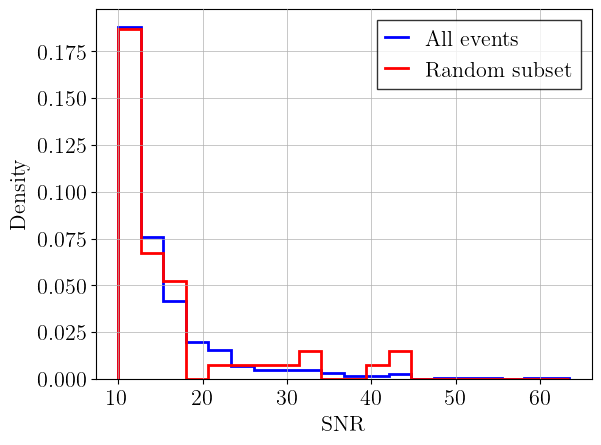

In [12]:
# Show the SNR of the sampled events
sampled_snr = snr_array[sampled_indices]

hist, bins = np.histogram(snr_array, bins = 20, density=True)
hist_sampled, _ = np.histogram(sampled_snr, bins = bins, density=True)
plt.stairs(hist, bins, fill = False, color = "blue", linewidth = 2, label = "All events")
plt.stairs(hist_sampled, bins, fill = False, color = "red", linewidth = 2, label = "Random subset")
plt.xlabel("SNR")
plt.ylabel("Density")
plt.legend()
plt.show()

## Also need the PSD for the runs

Again, this is on LDAS, but is also found on LHO.

TODO: this is actually a bit more annoying to read and process than I imagined it would be.

In [ ]:
# Use the EventTable to read the XML file
psd_xml_filename = "/home/thibeau.wouters/gw-datasets/H0_inference_O5/psds_O5.xml" # on CIT!

for name in ["process", "process_params"]:
    psd_table = EventTable.read(psd_xml_filename, tablename = name)

    # Get the keys of this table
    keys = psd_table.keys()
    print("keys")
    print(keys)

keys
['comment', 'cvs_entry_time', 'cvs_repository', 'domain', 'end_time', 'ifos', 'is_online', 'jobid', 'node', 'process_id', 'program', 'start_time', 'unix_procid', 'username', 'version']
keys
['param', 'process_id', 'program', 'type', 'value']
